## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
from datetime import datetime

Load model parameters:

In [3]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Baseline_w_Augm_local.json'
if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
p.keys()

dict_keys(['_comment', 'model_path', 'model_dir', 'clean_model_dir', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'log_file_name', 'log_level', 'disable_gpu', 'set_memory_growth', 'model_name', 'number_of_epochs', 'loss', 'BATCH_SIZE', 'seed', 'input_channels'])

Set logging:

In [4]:
# Set logging configuration
import logging
log_file_path = p['log_file_name']
logging.basicConfig(
    filename=log_file_path,
    filemode='w', 
    level=getattr(logging, p['log_level'])
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

#### Model parameters:

In [5]:
msg = 'Dataset:\n{}'.format(p['tf_ds_name'])
msg += '\nAugmentation:\nRandom Flipping: {}\nRandom 90deg Rotations: {}'.format(p['random_horizontal_flipping'],p['random_90deg_rotations'])
msg += '\nModel:\nArchitecture: {}'.format(p['model_name'])
msg += '\nLoss function: {}'.format(p['loss'])
msg += '\nEpochs: {}\n\n'.format(p['number_of_epochs'])
logging.info(msg)
print(msg)

Dataset:
MPP_dataset_no_pert_no_mask
Augmentation:
Random Flipping: 1
Random 90deg Rotations: 1
Model:
Architecture: baseline_CNN
Loss function: huber
Epochs: 2




In [6]:
# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    msg = 'External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH)
    logging.error(msg)
    raise Exception(msg)
else:
    msg='EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH)
    print(msg)
    logging.info(msg)
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
# Load external libraries
import Models as models_functions
from Models import Predef_models as predef_models
from Utils import Tee_Logger as Tee_Logger
import Utils as utils

EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace/libs


Create dirs where model output will be saved:

In [7]:
# If you want to avoid cleaning (deleting) model dir, then uncomment the next line:
#p['clean_model_dir'] = 0

base_path, model_path, checkpoints_path = utils.create_model_dirs(parameters=p)

msg = 'Base path:\n{}'.format(base_path)
msg += '\nModel path:\n{}'.format(model_path)
msg += '\nCheckpoints path:\n{}'.format(checkpoints_path)
logging.info(msg)
print(msg)

Warning! Directory /home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_CNN/No_perturbations already exist! Deleting...

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_CNN/No_perturbations
Base path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_CNN/No_perturbations
Model path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_CNN/No_perturbations/model
Checkpoints path:
/home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_CNN/No_perturbations/checkpoints


In [8]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    logging.info(msg)
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
logging.info(msg)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'
        
    logging.info(msg)
    print(msg)

Physical GPU devises:
[]
It was not possible to limit GPU memory


## Load Preprocessing parameters and information:

In [9]:
# Preprocessed data path
pp_path = p['pp_path']

with open(os.path.join(pp_path, 'params.json')) as pp_file:
    pp_params = json.load(pp_file)
msg = 'Loaded data preprocessing parameters from:\n{}'.format(pp_file)
logging.info(msg)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as channel_file:
    channels = pd.read_csv(channel_file)
msg = 'Loaded channels file from:\n{}'.format(channel_file)
logging.info(msg)
channels

channel_id               name
0            0            00_DAPI
1            1             07_H2B
2            2      01_CDK9_pT186
3            3            03_CDK9
4            4           05_GTF2B
5            5          07_SETD1A
6            6         08_H3K4me3
7            7           09_SRRM2
8            8         10_H3K27ac
9            9       11_KPNA2_MAX
10          10  12_RB1_pS807_S811
11          11          13_PABPN1
12          12            14_PCNA
13          13             15_SON
14          14              16_H3
15          15           17_HDAC3
16          16       19_KPNA1_MAX
17          17           20_SP100
18          18             21_NCL
19          19          01_PABPC1
20          20            02_CDK7
21          21            03_RPS6
22          22              05_Sm
23          23          07_POLR2A
24          24           09_CCNT1
25          25      10_POL2RA_pS2
26          26             11_PML
27          27            12_YAP1
28          28      13_POL2RA_pS5
29          29        15_U2SNRNPB
30          30            18_NONO
31          31          20_ALYREF
32          32            21_COIL
33          33           00_BG488
34          34           00_BG568
35          35              00_EU
36          36   09_SRRM2_ILASTIK
37          37     15_SON_ILASTIK

## Specify input channels

In [10]:
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
logging.info(msg)
print(msg)
print(input_ids.shape)

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(33,)


## Load Dataset

In [11]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=p['shuffle_files'],
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
logging.info(msg)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

Show information about the dataset:

In [12]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset_no_pert_no_mask',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' se

In [13]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=192>,
 'train': <tfds.core.SplitInfo num_examples=1507>,
 'validation': <tfds.core.SplitInfo num_examples=187>}

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [14]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)
    
    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images."""
    
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    if p['random_horizontal_flipping']:
        image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    if p['random_90deg_rotations']:
        k = np.random.randint(0,4)
        image = tf.image.rot90(image, k=k)
    
    return image, target

In [15]:
msg = ''
if p['random_horizontal_flipping']:
    msg = 'Random horizontal flipping for training set selected!'
if p['random_90deg_rotations']:
    msg = msg + '\nRandom 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!'
if msg == '':
    msg = 'No data augmentation technique selected for trainingset!'
logging.info(msg)
print(msg)

Random horizontal flipping for training set selected!
Random 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!


Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [16]:
def visualize_cell(image):
    plt.figure(figsize=(6,4))
    plt.title('Original Cell')
    plt.imshow(image.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    
    if p['random_horizontal_flipping'] | p['random_90deg_rotations']:
        plt.figure(figsize=(15,4))
        for i in range(4):
            img, _ = augment(image, 0)
            plt.subplot(1,4,i+1)
            plt.title('Augmented Cell')
            plt.imshow(img.numpy()[:,:,10:13],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)

In [17]:
# Get one image from the training dataset
image, _ = next(iter(train_data))

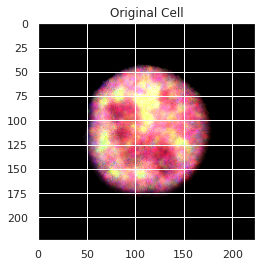

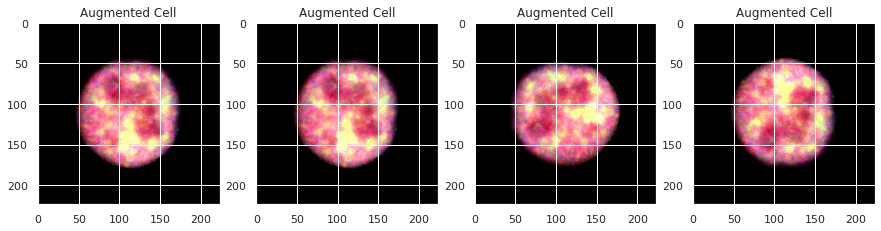

In [18]:
# Visualize the original vs. random flipping and rotations
visualize_cell(image)

Prepare datasets for training the CNN:

In [19]:
BATCH_SIZE = p['BATCH_SIZE']
buffer_size = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [20]:
# Init models class
models = predef_models()

# Select model
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)
model = models.select_model(model_name=p['model_name'], input_shape=img_shape)

baseline_CNN selected!


Select the loss function and build the model:

In [21]:
# Select the loss function
if p['loss'] == 'mse':
    loss = tf.keras.losses.MeanSquaredError()
    
elif p['loss'] == 'huber':
    loss = tf.keras.losses.Huber(delta=1.0)
msg = '{} loss function selected. Building the model...'.format(p['loss'])
logging.info(msg)
print(msg)

metrics = ['mse', 'mean_absolute_error']
model.compile(optimizer='adam',
              loss=loss,
              metrics=metrics
             )
msg = 'Model compiled!'
logging.info(msg)

huber loss function selected. Building the model...


Take a look into the model architecture and number of parameters:

In [22]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 128)     0

In [23]:
# Finish stdout duplication
TeeLog.close()

Redirect the systems standard output to the logfile, so we can see the training process in the server:

Set callback to save best model:

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoints_path+'/checkpoint',
#    save_weights_only=True,
    filepath=checkpoints_path+'/best_model',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
)

Train the model:

In [25]:
msg = 'Starting model training...'
logging.info(msg)

In [26]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)

# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=p['number_of_epochs'],
                    callbacks=[model_checkpoint_callback],
                    #verbose=1, #progress bar
                    verbose=2, #one line per epoch
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/checkpoints/best_model/assets
47/47 - 29s - loss: 323.0582 - mse: 110229.1953 - mean_absolute_error: 323.5582 - val_loss: 299.5984 - val_mse: 94113.7266 - val_mean_absolute_error: 300.0984
Epoch 2/50
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/checkpoints/best_model/assets
47/47 - 29s - loss: 129.8678 - mse: 25860.8691 - mean_absolute_error: 130.3668 - val_loss: 193.2403 - val_mse: 59061.7734 - val_mean_absolute_error: 193.7397
Epoch 3/50
INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/checkpoints/best_model/assets
47/47 - 29s - loss: 

In [27]:
# Finish stdout duplication
TeeLog.close()

In [28]:
msg = 'Saiving trained model'
logging.info(msg)

# Save model
model.save(model_path)

INFO:tensorflow:Assets written to: /storage/groups/ml01/code/andres.becker/master_thesis/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/model/assets


In [29]:
# Load best weights
#model.load_weights(checkpoints_path+'/checkpoint')
model.load_weights(os.path.join(checkpoints_path, 'best_model/variables/variables'))

In [30]:
# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history.history, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [31]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

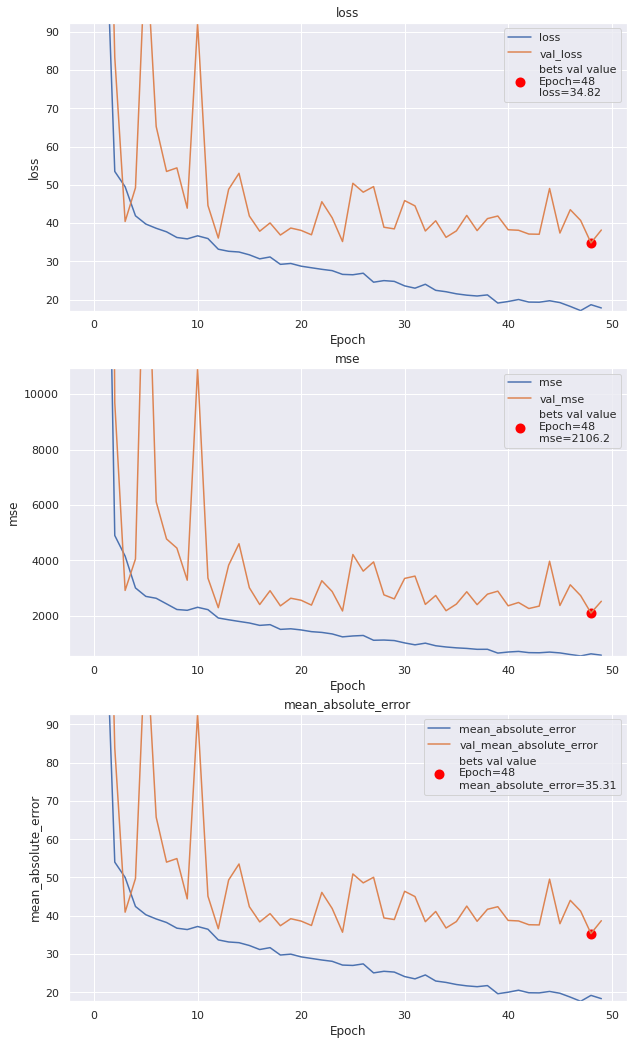

In [32]:
plt.figure(figsize=(10,18))
models_functions.plot_loss(history.history, metrics, p)

## Evaluate the whole Dataset

In [33]:
del(train_data, val_data, test_data)
del(dataset, metadata)

In [34]:
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [35]:
BATCH_SIZE = p['BATCH_SIZE']
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [36]:
columns = ['y', 'y_hat', 'mapobject_id_cell', 'set']
targets_df = pd.DataFrame(columns=columns)

dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
for ds, dsn in zip(dss, ds_names):
    for cells in ds:
        cell_ids = [cell_id.decode() for cell_id in cells['mapobject_id_cell'].numpy()]
        cell_ids = np.asarray(cell_ids).reshape(-1,1)
        Y = cells['target'].numpy()
        cell_imgs, _ = filter_channels(cells['image'], _)
        Y_hat = model.predict(cell_imgs)
        temp_df = pd.DataFrame(np.concatenate((Y, Y_hat), axis=1), columns=['y', 'y_hat'])
        temp_df['mapobject_id_cell'] = cell_ids
        temp_df['set'] = dsn
        targets_df = pd.concat((targets_df, temp_df), axis=0, ignore_index=True)

In [37]:
# Add perturbation info to the targets df
with open(os.path.join(p['pp_path'], 'metadata.csv'), 'r') as file:
    row_data_metadata = pd.read_csv(file)
    row_data_metadata.mapobject_id_cell = row_data_metadata.mapobject_id_cell.astype(str)
per_df = row_data_metadata[['mapobject_id_cell', 'perturbation']]
targets_df = targets_df.merge(
        per_df, 
        left_on='mapobject_id_cell',
        right_on='mapobject_id_cell',
        how='left',
)
targets_df

y       y_hat mapobject_id_cell    set perturbation
0     337.603180  432.323883            305670  train         DMSO
1     489.283569  445.045898            200732  train       normal
2     343.809692  387.570740            224274  train       normal
3     436.179108  365.330536            248989  train         DMSO
4     344.612427  369.750732            212764  train       normal
...          ...         ...               ...    ...          ...
3698  385.462708  389.363373            261401   test       normal
3699  414.214355  389.501526            194787   test       normal
3700  391.196686  369.832275            375051   test         DMSO
3701  401.894257  461.677612            251481   test       normal
3702  389.485474  443.142914            243862   test         DMSO

[3703 rows x 5 columns]

In [38]:
# Sava targets info
with open(os.path.join(base_path, 'targets.csv'), 'w') as file:
    targets_df.to_csv(file, index=False)

## Plot results
Now lets see how our model performs.

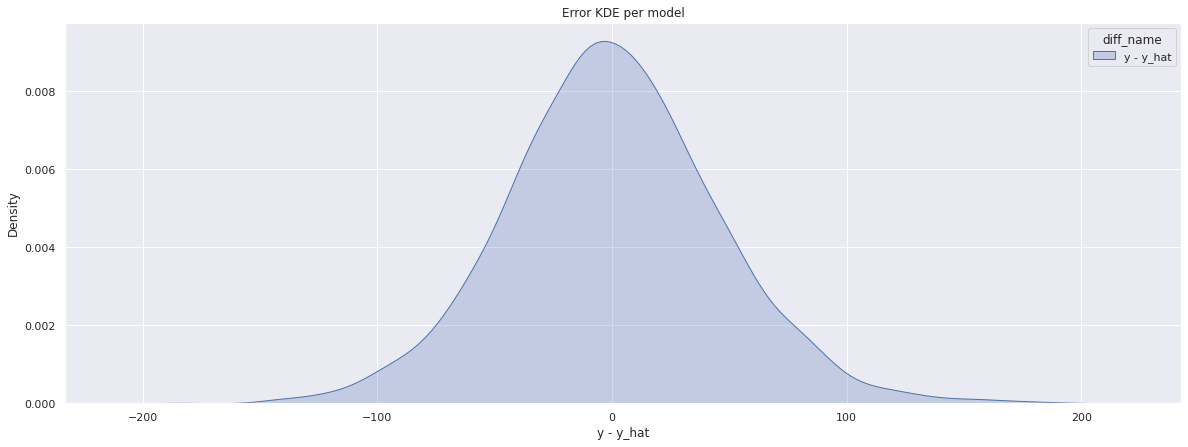

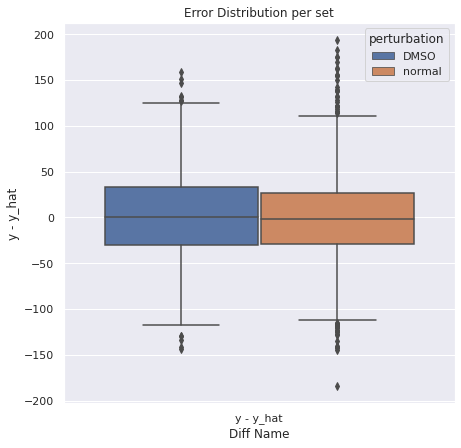

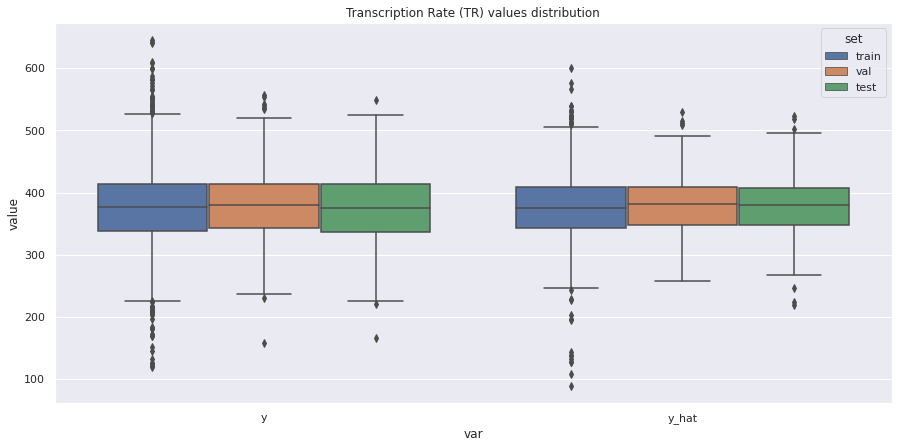

In [39]:
models_functions.plot_error_dist(df=targets_df, y_models=['y_hat'])

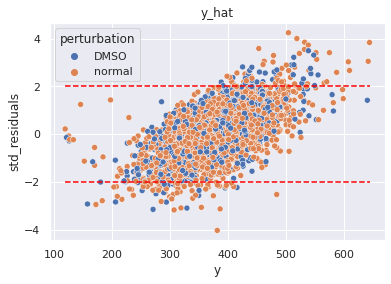

In [40]:
# Residual plot
models_functions.plot_residuals(df=targets_df, y_hat='y_hat')

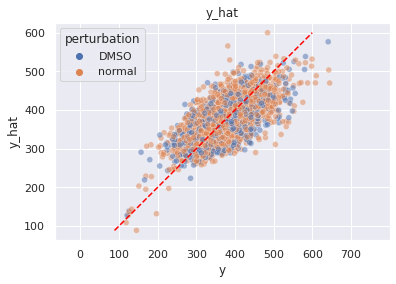

In [41]:
# Target vs predicted
models_functions.plot_y_vs_y_hat(df=targets_df, y_hat='y_hat')

In [42]:
metric_values = models_functions.get_metrics(df=targets_df)
# Sava metrics info
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metric_values.to_csv(file, index=False)
metric_values

model    set      R2 BIC        MSE      MAE    Huber
0  y_hat   test  0.3220   0  2076.1659  35.3034  34.8059
1  y_hat  train  0.4522   0  2077.3970  35.5309  35.0335
2  y_hat    val  0.3947   0  2106.2013  35.3137  34.8189

In [43]:
msg = 'Notebook execution finished!'
logging.info(msg)

In [6]:
base_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/'
# Sava targets info
with open(os.path.join(base_path, 'targets.csv'), 'r') as file:
    targets_df = pd.read_csv(file)
targets_df

y       y_hat  mapobject_id_cell    set perturbation
0     337.603180  432.323883             305670  train         DMSO
1     489.283569  445.045898             200732  train       normal
2     343.809692  387.570740             224274  train       normal
3     436.179108  365.330536             248989  train         DMSO
4     344.612427  369.750732             212764  train       normal
...          ...         ...                ...    ...          ...
3698  385.462708  389.363373             261401   test       normal
3699  414.214355  389.501526             194787   test       normal
3700  391.196686  369.832275             375051   test         DMSO
3701  401.894257  461.677612             251481   test       normal
3702  389.485474  443.142914             243862   test         DMSO

[3703 rows x 5 columns]

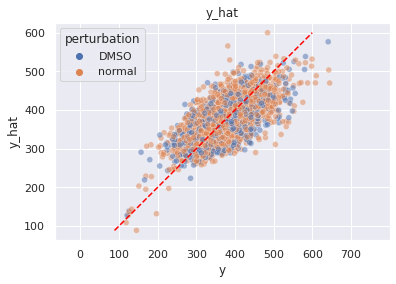

In [15]:
models_functions.plot_y_vs_y_hat(df=targets_df, y_hat='y_hat')

In [154]:
mask = ((targets_df['y'] >= 399) & (targets_df['y'] <= 401) & (targets_df['set'] == 'train'))
targets_df[mask].sort_values(by=['y_hat'])

y       y_hat  mapobject_id_cell    set perturbation
690   399.347473  324.741394             213604  train         DMSO
416   399.871338  332.875275             323166  train       normal
290   399.742950  344.371124             277404  train       normal
611   399.568665  347.526398             231511  train       normal
1151  400.842926  347.960815             199610  train       normal
2875  399.977814  356.416046             351938  train       normal
2301  400.040771  362.779175             383826  train       normal
2806  399.850281  366.800110             357483  train       normal
510   400.571289  369.223206             249308  train         DMSO
42    399.514679  375.335205             257440  train       normal
998   399.242493  386.236725             323141  train       normal
2687  400.614227  386.353485             227524  train       normal
121   400.196350  393.692596             321028  train       normal
2517  399.221222  396.398987             251466  train       normal
2336  399.138916  402.441254             378131  train       normal
1921  400.777283  404.170074             231510  train       normal
1279  399.688782  406.950806             324085  train       normal
2455  399.200073  407.223846             239124  train       normal
1434  400.956177  407.722900             324782  train       normal
2674  399.341064  408.875305             351223  train       normal
892   399.788696  409.678986             340555  train         DMSO
2886  399.702332  410.337036             375036  train         DMSO
1737  399.474670  411.123505             323130  train       normal
996   400.493134  411.220093             195522  train       normal
987   400.963959  412.456299             359416  train         DMSO
524   399.062988  415.070923             213588  train         DMSO
2837  399.020966  418.467987             212759  train       normal
2888  399.169556  419.468872             203462  train       normal
1831  399.002777  419.474854             372690  train         DMSO
2533  400.579346  420.360962             203441  train       normal
485   399.200684  424.302399             321020  train       normal
1088  399.303192  432.314056             298380  train       normal
303   399.498383  435.319122             359351  train       normal
507   400.173370  436.670044             208516  train       normal
352   399.683319  436.756561             320999  train       normal
1861  399.887268  436.834045             305680  train         DMSO
1182  400.403503  441.846008             224052  train       normal
2428  399.795044  442.824493             378121  train       normal
2641  399.315918  444.173645             275852  train       normal
1200  399.059631  450.567627             271037  train       normal
1176  399.778717  453.224304             258517  train       normal
1881  399.089630  473.559235             378150  train       normal

In [95]:
base_path

'/home/hhughes/Documents/Master_Thesis/Project/workspace/models/Without_Perturbations/baseline_CNN/131220_1017/'

In [155]:
low_cell_id = '213604'
high_cell_id = '378150'
midel_cell_id = '251466'
low2_cell_id = '323166'
high2_cell_id = '258517'

low_cell = np.load(os.path.join(base_path, low_cell_id+'.npz'))
high_cell = np.load(os.path.join(base_path, high_cell_id+'.npz'))
midel_cell = np.load(os.path.join(base_path, midel_cell_id+'.npz'))
low2_cell = np.load(os.path.join(base_path, low2_cell_id+'.npz'))
high2_cell = np.load(os.path.join(base_path, high2_cell_id+'.npz'))
low_cell.files

['img', 'mask', 'targets']

In [147]:
with open(os.path.join(base_path, 'coefs_Ridge.csv'), 'r') as file:
    coefs_Ridge = pd.read_csv(file)
columns = coefs_Ridge.columns
temp_df = pd.DataFrame(columns=columns)
temp_df = temp_df.append({'channel_id':35, 'Ridge_coef':'NaN', 'positive':True}, ignore_index=True)
coefs_Ridge = pd.concat((temp_df, coefs_Ridge)).reset_index()
coefs_Ridge = coefs_Ridge.drop(['index'], axis=1)
coefs_Ridge['positive']

coefs_Ridge.head(5)

channel_id Ridge_coef positive
0         35        NaN     True
1          0    203.529     True
2         26    201.726     True
3          9    117.021     True
4          7   -95.3398    False

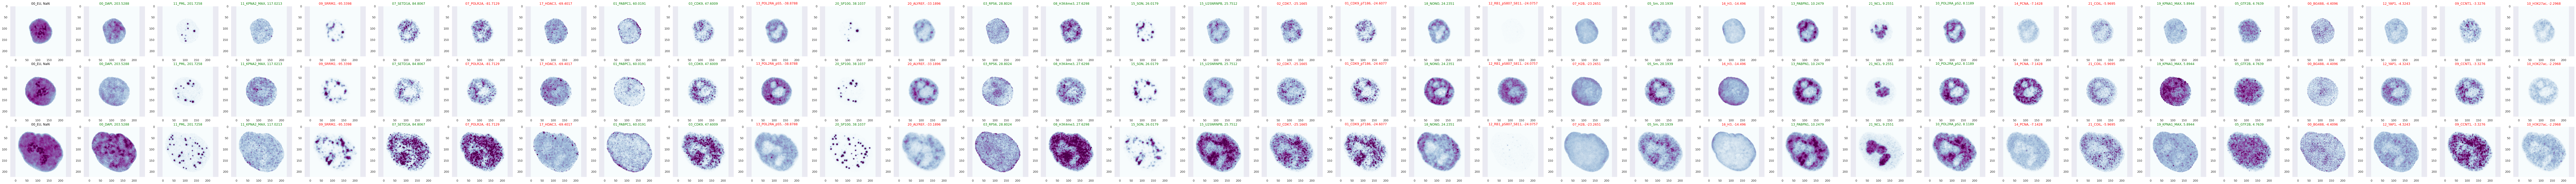

In [181]:
plot_ids=[low_cell_id, low2_cell_id, midel_cell_id, high2_cell_id, high_cell_id]
temp_data = [low_cell, low2_cell, midel_cell, high2_cell, high_cell]

plot_ids=[low_cell_id, midel_cell_id, high_cell_id]
temp_data = [low_cell, midel_cell, high_cell]

#plot_ids=[low_cell_id]
#temp_data = [low_cell]

n_cells = len(plot_ids)
n_channels = coefs_Ridge['channel_id'].values.shape[0]
n_plots = math.ceil(n_channels / 3)

plt.figure(figsize=(n_channels*5,n_cells*4))

n_plot = 1
for cell_id, cell in zip(plot_ids, temp_data):
    img = cell['img']
    for n_channel, c in enumerate(coefs_Ridge['channel_id'].values):
        mask = (channels['channel_id'] == c)
        c_name = channels[mask]['name'].values[0]
        
        mask = (coefs_Ridge['channel_id'] == c)
        positive = coefs_Ridge[mask]['positive'].values[0]
        coef = str(coefs_Ridge[mask]['Ridge_coef'].values[0])
        
        plt.subplot(n_cells, n_channels, n_plot)
        plt.imshow(img[:,:,c],
                   cmap='BuPu',
                   vmin=0, vmax=1)
        plt.axis('equal')
        plt.grid(False)
        if positive:
            color='green'
        elif not positive:
            color='red'
        if c== 35:
            color='black'
        #plt.title(cell_id+'\n'+c_name, color=color)
        plt.title(c_name+', '+coef, color=color)
        n_plot += 1
plt.show()

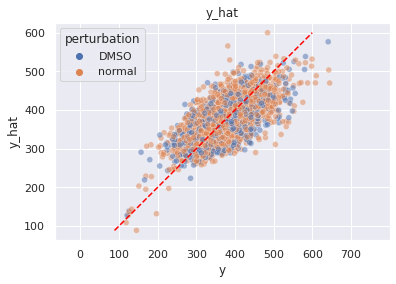

In [160]:
models_functions.plot_y_vs_y_hat(df=targets_df, y_hat='y_hat')

In [169]:
#mask = ((targets_df['y'] >= 399) & (targets_df['y'] <= 401) & (targets_df['set'] == 'train'))
mask = (targets_df['set'] == 'train')
targets_df[mask].sort_values(by=['y'])

y       y_hat  mapobject_id_cell    set perturbation
1058  118.842827  109.034973             321003  train       normal
1483  121.196419  127.720619             241664  train         DMSO
1477  124.775452  128.395233             324769  train       normal
1190  125.948196  139.020599             233624  train         DMSO
1867  126.741425  137.354050             340174  train       normal
...          ...         ...                ...    ...          ...
1254  608.284912  470.269226             271206  train       normal
657   610.357788  488.817932             303030  train       normal
2174  641.162903  576.566223             291653  train         DMSO
2597  642.660767  503.646179             380612  train       normal
2007  644.971497  469.999817             262901  train       normal

[2959 rows x 5 columns]

In [178]:
lowest_cell_id = '321003'
#lowest_cell_id = '241664'
highest_cell_id = '262901'

lowest_cell = np.load(os.path.join(base_path, lowest_cell_id+'.npz'))
highest_cell = np.load(os.path.join(base_path, highest_cell_id+'.npz'))

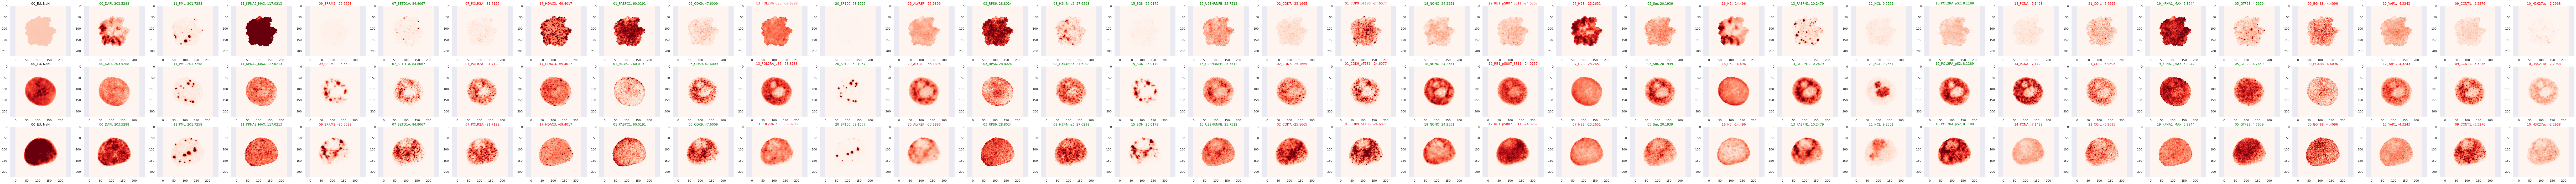

In [180]:
plot_ids=[lowest_cell_id, midel_cell_id, highest_cell_id]
temp_data = [lowest_cell, midel_cell, highest_cell]

#plot_ids=[low_cell_id]
#temp_data = [low_cell]

n_cells = len(plot_ids)
n_channels = coefs_Ridge['channel_id'].values.shape[0]
n_plots = math.ceil(n_channels / 3)

#plt.figure(figsize=2*(n_channels*5,n_cells*4))
plt.figure(figsize=(n_channels*5,n_cells*4))

n_plot = 1
for cell_id, cell in zip(plot_ids, temp_data):
    img = cell['img']
    for n_channel, c in enumerate(coefs_Ridge['channel_id'].values):
        mask = (channels['channel_id'] == c)
        c_name = channels[mask]['name'].values[0]
        
        mask = (coefs_Ridge['channel_id'] == c)
        positive = coefs_Ridge[mask]['positive'].values[0]
        coef = str(coefs_Ridge[mask]['Ridge_coef'].values[0])
        
        plt.subplot(n_cells, n_channels, n_plot)
        plt.imshow(img[:,:,c],
                   cmap='Reds',
                   vmin=0, vmax=1)
        plt.axis('equal')
        plt.grid(False)
        if positive:
            color='green'
        elif not positive:
            color='red'
        if c== 35:
            color='black'
        #plt.title(cell_id+'\n'+c_name, color=color)
        plt.title(c_name+', '+coef, color=color)
        n_plot += 1
plt.show()